### Notebook to generate Supp Figure 4B

In [1]:
## import statement

import matplotlib
from matplotlib import pyplot as plt
import seaborn
import scanpy
import pandas
from typing import Tuple, Any, List, Union
import numpy as np
import torch
import os
from anndata import read_h5ad
from scanpy import pp
import pandas as pd
import umap
import scanpy as sc
import random
import pickle

# tissue_purifier import
import tissue_purifier as tp

In [ ]:
from tissue_purifier.genex.gene_utils import *
from tissue_purifier.genex.poisson_glm import *
from tissue_purifier.utils import *
from tissue_purifier.plots import *

In [2]:
## pytorch

torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.FloatTensor)

/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [3]:
## set seeds
r_seed=t_seed=n_seed=100

random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)



In [4]:
## plotting parameters

linewidth = 5
tickfontsize = 80
labelfontsize = 80
labelpad = 40
titlefontsize=80
legendfontsize=80
legendmarkersize=4

In [5]:
## Set working directory

import os
os.chdir("/home/skambha6/chenlab/tissue_purifier/TissueMosaic_Figures/Supp_Figure4/plots")

## Load data and create sparse images

In [6]:
anndata_dest_folder='/home/skambha6/chenlab/tissue_purifier/data/testis_anndata_corrected_doubletmode_annotated/'

# Make a list of all the h5ad files in the annotated_anndata_dest_folder
fname_list = []
for f in os.listdir(anndata_dest_folder):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

['wt3_dm.h5ad', 'wt1_dm.h5ad', 'diabetes2_dm.h5ad', 'wt2_dm.h5ad', 'diabetes1_dm.h5ad', 'diabetes3_dm.h5ad']


In [7]:
all_ckpts = ["testis_dino_ckpt_val_sweep_gr_best.pt"]

all_models = ["dino"]
all_ckpts_dest = []
for ckpt in all_ckpts:
    ckpt_dest = os.path.join("/home/skambha6/chenlab/tissue_purifier/model_checkpoints/testis/", ckpt)
    all_ckpts_dest.append(ckpt_dest)
    
print(all_ckpts_dest)

['/home/skambha6/chenlab/tissue_purifier/model_checkpoints/testis/testis_dino_ckpt_val_sweep_gr_best.pt']


In [8]:
model_name = "dino"

In [9]:
from tissue_purifier.utils import *
from tissue_purifier.plots import *

In [10]:
from tissue_purifier.data import AnndataFolderDM
from tissue_purifier.models.ssl_models import *
# now you have access to Barlow, SImclr, Dino, Vae

sp_images = []

for ckpt_path, model_name in zip(all_ckpts_dest, all_models):
    
    print("----------")
    print("Model --->", model_name, ckpt_path)
    print("----------")
    
    # load the model from checkpoint
    if model_name == "barlow":
        model = tp.models.ssl_models.Barlow.load_from_checkpoint(checkpoint_path=ckpt_path, strict=False)
    elif model_name == "simclr":
        model = tp.models.ssl_models.Simclr.load_from_checkpoint(checkpoint_path=ckpt_path, strict=False)
    elif model_name == "dino":
        model = tp.models.ssl_models.Dino.load_from_checkpoint(checkpoint_path=ckpt_path, strict=False)
    elif model_name == "vae":
        model = tp.models.ssl_models.Vae.load_from_checkpoint(checkpoint_path=ckpt_path, strict=False)
    else:
        raise Exception("Model name not recongnized {}".format(model_name))
        
    # create the datamodule associated with the pretrained model
    dm = tp.data.AnndataFolderDM(**model._hparams) 
    
    # put the model on GPU if available
    if torch.cuda.is_available():
        model = model.cuda()
    
    # process all the anndata with the model-datamodule pair
    patch_repr = []
    ncv_repr = []
    for i in range(len(fname_list)):
        
        fname = fname_list[i]
        
        # open adata and convert to sparse_image
        adata_path = os.path.join(anndata_dest_folder, fname)
        adata = read_h5ad(adata_path)
        #adata = adata[adata.obs.index.isin(anndata.obs.index),:]
        
        sp_img = dm.anndata_to_sparseimage(adata)

        sp_images.append(sp_img)
        # free memory by erasing the sparse_image
        del sp_img
    
    # after loop over anndata erase the model and free memory
    del model   

[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and func

----------
Model ---> dino /home/skambha6/chenlab/tissue_purifier/model_checkpoints/testis/testis_dino_ckpt_val_sweep_gr_best.pt
----------


/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


number of elements ---> 35797
mean and median spacing 15.760547246990356, 15.570735462452099
The dense shape of the image is -> torch.Size([9, 1179, 1180])
number of elements ---> 29178
mean and median spacing 15.90507495709278, 15.497339152935078
The dense shape of the image is -> torch.Size([9, 1178, 1175])
number of elements ---> 27840
mean and median spacing 16.009033744023068, 15.768961335552781
The dense shape of the image is -> torch.Size([9, 1160, 1143])
number of elements ---> 29607
mean and median spacing 15.810478612949094, 15.727658385209352
The dense shape of the image is -> torch.Size([9, 1180, 855])
number of elements ---> 30132
mean and median spacing 16.353857684013548, 15.931447916615909
The dense shape of the image is -> torch.Size([9, 1180, 1180])
number of elements ---> 34868
mean and median spacing 15.821949004591055, 15.638433550603624
The dense shape of the image is -> torch.Size([9, 1180, 1181])


## Plot spot train/test split

In [11]:
sample_sp_img = sp_images[0]

In [12]:
# y_boundary = y_median +/- patch_width
# x_boundary = x_median +/- patch_width

spots_x_key = sample_sp_img.spot_properties_dict['x_key']
spots_y_key = sample_sp_img.spot_properties_dict['y_key']
# spots = sample_sp_img.get_spot_properties_dict()['dino_spot_features']

x_median = np.median(spots_x_key)
y_median = np.median(spots_y_key)
                     
print(x_median)
print(y_median)                 

## assuming patches are squares with same width/height; otherwise need to set separate boundaries for x and y
# patch_size = sample_sp_img.get_patch_properties_dict()['dino_patch_xywh'][0][2] ## "w" entry 
patch_size = 96

boundary = sample_sp_img.pixel_size * patch_size
print(boundary)            

3138.0
3183.6
384.0


In [13]:
## divide puck into quadrants; each quadrant is a test fold, train fold are the other 3 quadrants - boundary

def spot_train_test_split(sample_sp_img, spots_x_key, x_median, spots_y_key, y_median):
    ## fold 1
    test_fold_1_inds = np.where((spots_x_key > x_median) & (spots_y_key > y_median))[0]

    train_fold_1_inds_1 = np.where((spots_x_key < (x_median - boundary)))[0]
    train_fold_1_inds_2 = np.where(spots_y_key < (y_median - boundary))[0]
    
    
    train_fold_1_inds = np.concatenate((train_fold_1_inds_1, train_fold_1_inds_2))
    print("fold 1:")
    print(train_fold_1_inds.shape)
    print(test_fold_1_inds.shape)

    train_test_fold_1 = -1*np.ones(spots_x_key.shape)

    ## 0 train
    ## 1 test
    ## -1 discard
    train_test_fold_1[train_fold_1_inds] = 0
    train_test_fold_1[test_fold_1_inds] = 1


    sample_sp_img.write_to_spot_dictionary(key = 'train_test_fold_1', values=train_test_fold_1, overwrite=True)

    ## fold 2 
    test_fold_2_inds = np.where(np.logical_and(spots_x_key > x_median,spots_y_key < y_median))[0]

    train_fold_2_inds_1 = np.where((spots_x_key < (x_median - boundary)))[0]
    train_fold_2_inds_2 = np.where((spots_y_key > (y_median + boundary)))[0]
    train_fold_2_inds = np.concatenate((train_fold_2_inds_1, train_fold_2_inds_2))
    
    print("fold 2:")
    print(train_fold_2_inds.shape)
    print(test_fold_2_inds.shape)

    train_test_fold_2 = -1*np.ones(spots_x_key.shape)

    ## 0 train
    ## 1 test
    ## -1 discard
    train_test_fold_2[train_fold_2_inds] = 0
    train_test_fold_2[test_fold_2_inds] = 1


    sample_sp_img.write_to_spot_dictionary(key = 'train_test_fold_2', values=train_test_fold_2, overwrite=True)


    ## fold 3
    test_fold_3_inds = np.where(np.logical_and(spots_x_key < x_median,spots_y_key > y_median))[0]

    train_fold_3_inds_1 = np.where((spots_x_key > (x_median + boundary)))[0]
    train_fold_3_inds_2 = np.where((spots_y_key < (y_median - boundary)))[0]
    train_fold_3_inds = np.concatenate((train_fold_3_inds_1, train_fold_3_inds_2))
    print("fold 3:")
    print(train_fold_3_inds.shape)
    print(test_fold_3_inds.shape)

    train_test_fold_3 = -1*np.ones(spots_x_key.shape)

    ## 0 train
    ## 1 test
    ## -1 discard
    train_test_fold_3[train_fold_3_inds] = 0
    train_test_fold_3[test_fold_3_inds] = 1

    sample_sp_img.write_to_spot_dictionary(key = 'train_test_fold_3', values=train_test_fold_3, overwrite=True)


    ## fold 4
    test_fold_4_inds = np.where(np.logical_and(spots_x_key < x_median,spots_y_key < y_median))[0]

    train_fold_4_inds_1 = np.where((spots_x_key > (x_median + boundary)))[0]
    train_fold_4_inds_2 = np.where((spots_y_key > (y_median + boundary)))[0]
    train_fold_4_inds = np.concatenate((train_fold_4_inds_1, train_fold_4_inds_2))
    print("fold 4:")
    print(train_fold_4_inds.shape)
    print(test_fold_4_inds.shape)

    train_test_fold_4 = -1*np.ones(spots_x_key.shape)

    ## 0 train
    ## 1 test
    ## -1 discard
    train_test_fold_4[train_fold_4_inds] = 0
    train_test_fold_4[test_fold_4_inds] = 1

    sample_sp_img.write_to_spot_dictionary(key = 'train_test_fold_4', values=train_test_fold_4, overwrite=True)

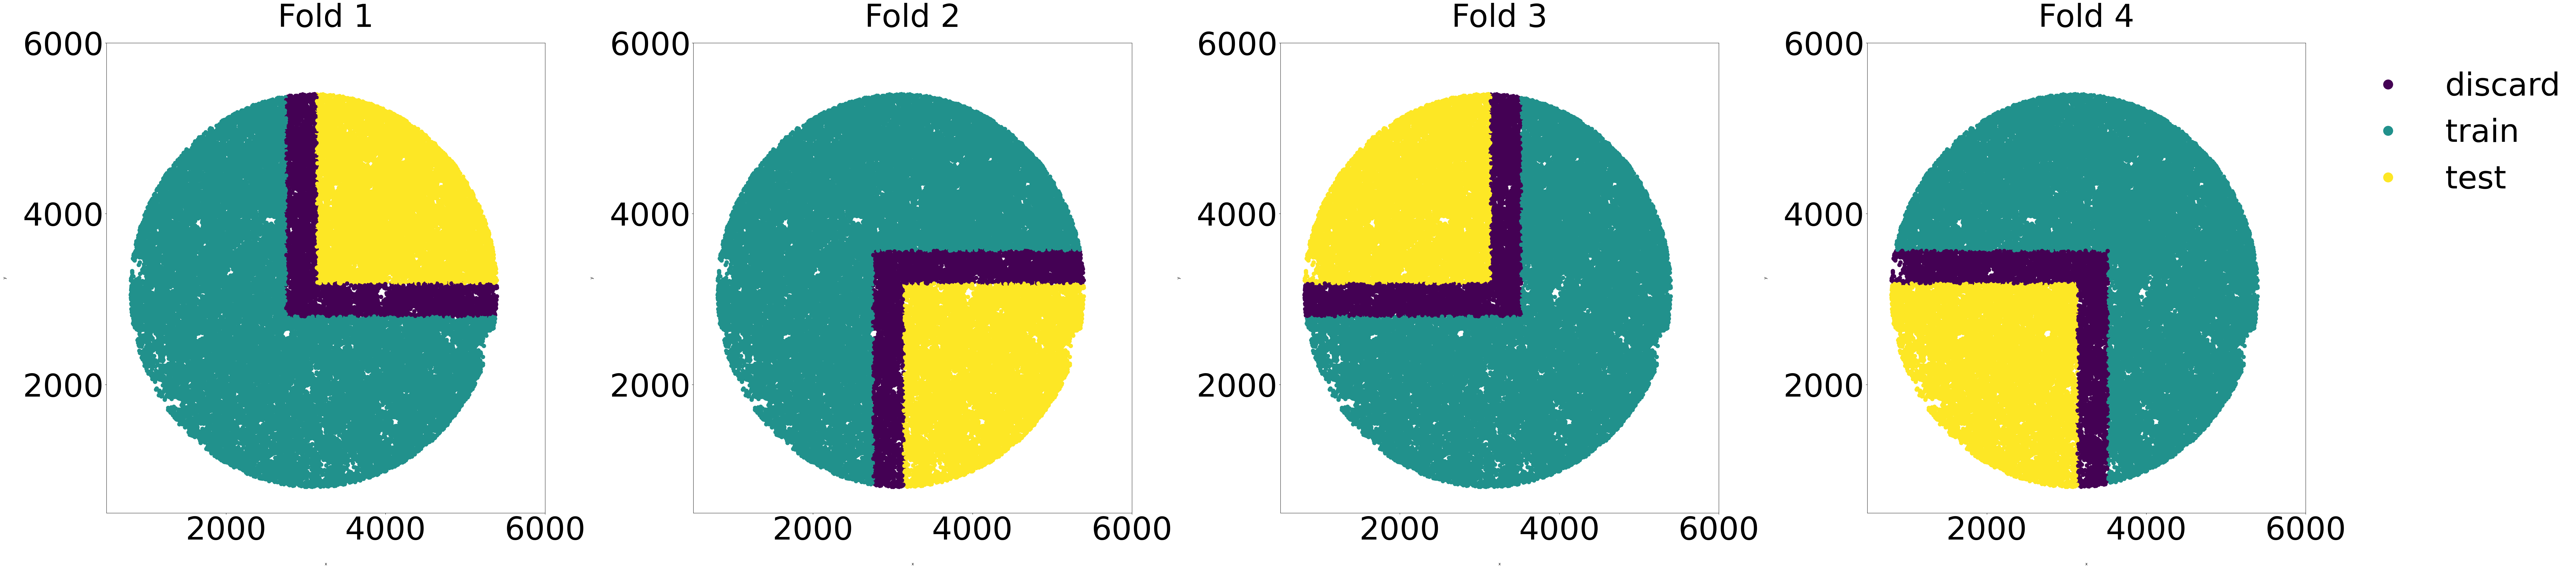

In [15]:
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


s = 100

# Create a figure
fig = plt.figure(figsize=(90, 20))


gs = gridspec.GridSpec(1, 4)

# Create subplots by specifying their position in the GridSpec
ax1 = fig.add_subplot(gs[0, 0])

scatter = ax1.scatter(spots_x_key, spots_y_key, c=pd.Series(sample_sp_img.spot_properties_dict['train_test_fold_1'],dtype="category"),s=s, rasterized=True)
ax1.set_xlim(500,6000)
ax1.set_ylim(500,6000)
ax1.set_xlabel('x', labelpad=labelpad)
ax1.set_ylabel('y', labelpad=labelpad)
ax1.set_xticks([2000, 4000, 6000])
ax1.set_yticks([2000, 4000, 6000])
ax1.tick_params(axis='both', labelsize=tickfontsize)
ax1.set_title("Fold 1", fontsize=titlefontsize, pad=labelpad)
ax1.grid(False)

ax2 = fig.add_subplot(gs[0,1])

scatter = ax2.scatter(spots_x_key, spots_y_key, c=pd.Series(sample_sp_img.spot_properties_dict['train_test_fold_2'],dtype="category"),s=s, rasterized=True)
ax2.set_xlim(500,6000)
ax2.set_ylim(500,6000)
ax2.set_xlabel('x', labelpad=labelpad)
ax2.set_ylabel('y', labelpad=labelpad)
ax2.set_xticks([2000, 4000, 6000])
ax2.set_yticks([2000, 4000, 6000])
ax2.tick_params(axis='both', labelsize=tickfontsize)
ax2.set_title("Fold 2", fontsize=titlefontsize, pad=labelpad)
ax2.grid(False)

ax3 = fig.add_subplot(gs[0,2])
scatter = ax3.scatter(spots_x_key, spots_y_key, c=pd.Series(sample_sp_img.spot_properties_dict['train_test_fold_3'],dtype="category"),s=s, rasterized=True)
ax3.set_xlim(500,6000)
ax3.set_ylim(500,6000)
ax3.set_xlabel('x', labelpad=labelpad)
ax3.set_ylabel('y', labelpad=labelpad)
ax3.set_xticks([2000, 4000, 6000])
ax3.set_yticks([2000, 4000, 6000])
ax3.tick_params(axis='both', labelsize=tickfontsize)
ax3.set_title("Fold 3", fontsize=titlefontsize, pad=labelpad)
ax3.grid(False)

ax4 = fig.add_subplot(gs[0,3])
scatter = ax4.scatter(spots_x_key, spots_y_key, c=pd.Series(sample_sp_img.spot_properties_dict['train_test_fold_4'],dtype="category"),s=s, rasterized=True)
ax4.set_xlim(500,6000)
ax4.set_ylim(500,6000)
ax4.set_xlabel('x', labelpad=labelpad)
ax4.set_ylabel('y', labelpad=labelpad)
ax4.set_xticks([2000, 4000, 6000])
ax4.set_yticks([2000, 4000, 6000])
ax4.tick_params(axis='both', labelsize=tickfontsize)
ax4.set_title("Fold 4", fontsize=titlefontsize, pad=labelpad)
ax4.grid(False)


handles, _ = scatter.legend_elements(prop="colors", alpha=1.0) 
legend1 = ax4.legend(handles, ['discard', 'train', 'test'],
                    bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legendfontsize, frameon=False,
                    markerscale=legendmarkersize)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

fig.savefig("supp_fig_4b.pdf", bbox_inches="tight", transparent=True, dpi=300)